# Notebook: fine-tune MedSAMLite (segment anything on Medical Data) on a custom dataset

# Notebook: fine-tune MedSAMLite (segment anything on Medical Data) on a custom dataset
In this notebook, our goal is to fine-tune the  model specifically for the task of stroke occlusion segmentation.

Resources used to create this notebook (🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).
* [Tutorial repository](https://github.com/NielsRogge/Transformers-Tutorials).

## Set-up environment
We already have our data and the MedSAM model locally. We will have to process them to input them into our model.

We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [2]:
!pip install -q monai


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader

## Load dataset

Here we load a dataset of 12 539 (image, ground truth mask) pairs.

The dataset utilized in this project originates from the ETIS database. We extracted images from the `.nii.gz` files of each brain's SWI-MRI along with their corresponding masks.


In [3]:
class OnTheFlyDataset(Dataset):
    def __init__(self, input_folder, label_folder):
        self.input_folder = input_folder
        self.label_folder = label_folder
        self.input_files = [f for f in sorted(os.listdir(input_folder)) if f.endswith('.npy')]
        self.label_files_map = {f.replace('_mask_slice_', '_image_slice_'): f for f in sorted(os.listdir(label_folder)) if f.endswith('.npy')}

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_filename = self.input_files[idx]
        print(self.input_files[idx])
        label_filename = self.label_files_map.get(input_filename)

        if label_filename:
            input_path = os.path.join(self.input_folder, input_filename)
            label_path = os.path.join(self.label_folder, label_filename)

            input_array = np.load(input_path)

            label_array = np.load(label_path)

            # transform the numpy arrays to tensors if necessary  : torch.from_numpy(input_array), same for label

            return input_array, label_array
        else:
            print(f"No corresponding mask found for {input_filename}") #if there is no corresponding mask


input_folder = 'E:/data/MEDSAM_finetuning/SWI_slice_Images' 
label_folder = 'E:/data/MEDSAM_finetuning/Masks_slice' 
dataset = OnTheFlyDataset(input_folder, label_folder)
data_loader = DataLoader(dataset, batch_size=2, num_workers=0) 



## Verify Data Loading

In [4]:
first_image = np.load('E:/data/MEDSAM_finetuning/SWI_slice_Images/2018-104_01-10087-D0MR_image_slice_30.npy')
import nibabel as nib
# second_image = nib.load('E:/data/SWI/2018-104_02-10428-D0MR_801_SWIp_50s_.nii.gz')

print(first_image.shape)

(480, 640)


In [8]:
print(f"Total number of samples in the dataset: {len(dataset)}")

sample_input, sample_label = dataset[0]  # load one sample from the dataset

print(f"Shape of the input sample: {sample_input.shape}")
print(f"Shape of the label sample: {sample_label.shape}")


Total number of samples in the dataset: 363
2018-104_01-10087-D0MR_image_slice_30.npy
Shape of the input sample: (480, 640)
Shape of the label sample: (480, 640)


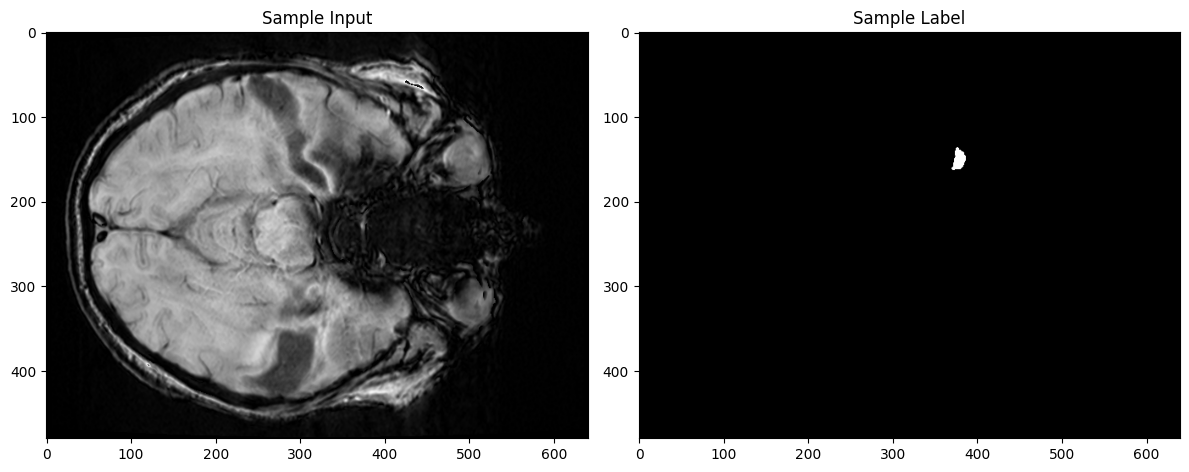

In [9]:
import matplotlib.pyplot as plt

# Assuming sample_input and sample_label are your image and label arrays respectively
plt.figure(figsize=(12, 6))

# Plotting the sample input image
plt.subplot(1, 2, 1)
plt.imshow(sample_input, cmap='gray')  # Preserves the original aspect ratio
plt.title('Sample Input')

# Plotting the sample label image
plt.subplot(1, 2, 2)
plt.imshow(sample_label, cmap='gray')  # Preserves the original aspect ratio
plt.title('Sample Label')

plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()
